# Faster R-CNN

In [3]:
!pip install -q selectivesearch
!pip install -q torch_snippets
from torch_snippets import *
from torchvision import transforms, models, datasets
from torchvision.ops import nms
import torch
from torch import optim
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.4 MB/s eta 0:00:00


In [25]:

from google.colab import drive
drive.mount('/content/drive')

# Correct the path to the dataset
datapath = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamidrezahazaveh","key":"01abd6b08d4ffaabca3e991cc8d2bedd"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d sixhky/open-images-bus-trucks

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
 99% 364M/367M [00:10<00:00, 38.9MB/s]
100% 367M/367M [00:10<00:00, 35.6MB/s]


In [8]:
import zipfile
import os

# Path to the downloaded zip file
with zipfile.ZipFile('open-images-bus-trucks.zip', 'r') as zip_ref:
    zip_ref.extractall('bus_trucks')

In [9]:
os.listdir('bus_trucks')

['images', 'df.csv']

In [10]:
import pandas as pd

IMAGE_ROOT = 'bus_trucks/images/images'
# Adjust the file name as needed
DF_RAW = df = pd.read_csv('bus_trucks/df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


# Working details of YOLO

In [11]:
!pip install -q ultralytics
import cv2
from ultralytics import YOLO

In [12]:
model = YOLO("yolo11x.pt")

In [13]:
def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results

def predict_and_detect(chosen_model, img, classes=[], conf=0.5, rectangle_thickness=2, text_thickness=1):
    results = predict(chosen_model, img, classes, conf=conf)
    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), rectangle_thickness)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), text_thickness)
    return img, results

In [14]:
image = cv2.imread(r"/content/bus_trucks/images/images/0068633242ebb5da.jpg")
result_img, _ = predict_and_detect(model, image, classes=[], conf=0.5)


0: 448x640 2 persons, 4 cars, 1 bus, 71.0ms
Speed: 5.0ms preprocess, 71.0ms inference, 869.7ms postprocess per image at shape (1, 3, 448, 640)


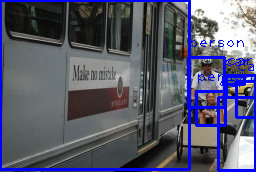

True

In [15]:
# cv2.imshow("Image", result_img)
# cv2.imwrite("result_img.jpg", result_img)
# cv2.waitKey(0)

from google.colab.patches import cv2_imshow  # Ensure this is imported
import cv2

# Display the image
cv2_imshow(result_img)

# Save the image
cv2.imwrite("result_img.jpg", result_img)




In [16]:
# defining function for creating a writer (for mp4 videos)
def create_video_writer(video_cap, output_filename):
    # grab the width, height, and fps of the frames in the video stream.
    frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_cap.get(cv2.CAP_PROP_FPS))
    # initialize the FourCC and a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    writer = cv2.VideoWriter(output_filename, fourcc, fps,
                             (frame_width, frame_height))
    return writer

In [17]:
# output_filename = "street_output.mp4"

# video_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street2.mp4"
# cap = cv2.VideoCapture(video_path)
# writer = create_video_writer(cap, output_filename)
# while True:
#     success, img = cap.read()
#     if not success:
#         break
#     result_img, _ = predict_and_detect(model, img, classes=[], conf=0.5)
#     writer.write(result_img)
#     cv2.imshow("Image", result_img)

#     cv2.waitKey(1)
# writer.release()

from google.colab.patches import cv2_imshow
import cv2

# Define the paths
video_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street2.mp4"
output_filename = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street_output.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Ensure the video file is opened successfully
if not cap.isOpened():
    raise ValueError(f"Failed to open video file at {video_path}")

# Create the video writer
writer = create_video_writer(cap, output_filename)

while True:
    success, img = cap.read()
    if not success:
        break

    # Perform prediction and detection
    result_img, _ = predict_and_detect(model, img, classes=[], conf=0.5)

    # Write the processed frame to the output video
    writer.write(result_img)

    # Optionally display the frame (uncomment for debugging or visualization)
    # cv2_imshow(result_img)

# Release resources
cap.release()
writer.release()
print(f"Video processing completed. Saved to: {output_filename}")




0: 384x640 (no detections), 66.8ms
Speed: 1.3ms preprocess, 66.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 63.1ms
Speed: 1.1ms preprocess, 63.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 48.9ms
Speed: 1.4ms preprocess, 48.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 36.7ms
Speed: 1.8ms preprocess, 36.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 36.5ms
Speed: 1.5ms preprocess, 36.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.7ms
Speed: 1.8ms preprocess, 35.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.7ms
Speed: 1.6ms preprocess, 35.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.6ms
Speed: 1.1ms preprocess, 33.6ms i

In [20]:
!pip install -q ultralytics deep_sort_realtime

import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np

# Load the YOLO model
model = YOLO("yolo11x.pt")

# Initialize the DeepSORT tracker
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Function for creating a video writer (for MP4 videos)
def create_video_writer(video_cap, output_filename):
    frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    writer = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width, frame_height))
    return writer

# Perform prediction and tracking
def predict_and_track(chosen_model, tracker, img, conf=0.5, rectangle_thickness=2, text_thickness=1):
    results = chosen_model.predict(img, conf=conf)
    detections = []

    # Extract bounding boxes and class IDs
    for result in results:
        for box in result.boxes:
            bbox = [
                int(box.xyxy[0][0]),
                int(box.xyxy[0][1]),
                int(box.xyxy[0][2]) - int(box.xyxy[0][0]),
                int(box.xyxy[0][3]) - int(box.xyxy[0][1]),
            ]
            score = float(box.conf[0])
            class_id = int(box.cls[0])
            if class_id == 2:  # Filter for cars (COCO class ID for "car")
                detections.append((bbox, score, class_id))

    # Update the tracker
    tracks = tracker.update_tracks(detections, frame=img)

    # Find the car closest to the center
    frame_center = (img.shape[1] // 2, img.shape[0] // 2)  # (center_x, center_y)
    closest_track = None
    min_distance = float('inf')

    for track in tracks:
        if not track.is_confirmed():
            continue
        bbox = track.to_ltwh()  # Get bounding box in (x, y, w, h) format
        center_x = int(bbox[0] + bbox[2] / 2)
        center_y = int(bbox[1] + bbox[3] / 2)
        distance = np.sqrt((center_x - frame_center[0]) ** 2 + (center_y - frame_center[1]) ** 2)
        if distance < min_distance:
            min_distance = distance
            closest_track = track

    # Annotate the image
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        bbox = track.to_ltwh()  # Get bounding box in (x, y, w, h) format
        bbox_color = (0, 0, 255) if track == closest_track else (255, 0, 0)  # Red for closest, Blue for others
        cv2.rectangle(
            img,
            (int(bbox[0]), int(bbox[1])),
            (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])),
            bbox_color,
            rectangle_thickness
        )
        cv2.putText(
            img,
            f"ID {track_id}",
            (int(bbox[0]), int(bbox[1]) - 10),
            cv2.FONT_HERSHEY_PLAIN,
            1,
            bbox_color,
            text_thickness
        )

    return img

# Define the paths
video_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street2.mp4"
output_filename = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/Street_Tracker.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f"Failed to open video file at {video_path}")

# Create the video writer
writer = create_video_writer(cap, output_filename)

frame_count = 0
try:
    while True:
        success, img = cap.read()
        if not success:
            break

        # Perform prediction and tracking
        result_img = predict_and_track(model, tracker, img, conf=0.5)

        # Write the processed frame to the output video
        writer.write(result_img)

        # Log progress
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processed {frame_count} frames...")

except Exception as e:
    print(f"An error occurred during processing: {e}")

finally:
    # Release resources
    cap.release()
    writer.release()
    print(f"Video processing with tracking completed. Saved to: {output_filename}")





0: 384x640 (no detections), 50.1ms
Speed: 2.2ms preprocess, 50.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 49.2ms
Speed: 1.7ms preprocess, 49.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 49.1ms
Speed: 1.7ms preprocess, 49.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.3ms
Speed: 1.1ms preprocess, 43.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.9ms
Speed: 1.7ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.5ms
Speed: 1.6ms preprocess, 34.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 34.4ms
Speed: 1.6ms preprocess, 34.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 33.9ms
Speed: 1.5ms preprocess, 33.9ms i

In [21]:
from google.colab import files
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Install necessary tools and packages
!apt-get install -y tesseract-ocr
!pip install -q pytesseract deep_sort_realtime

import cv2
import pytesseract
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load the Haar cascade for license plate detection
cascade_path = cv2.data.haarcascades + "haarcascade_russian_plate_number.xml"
plate_cascade = cv2.CascadeClassifier(cascade_path)

# Initialize the DeepSORT tracker
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Function to detect license plates and extract text using OCR
def detect_license_plate_with_haar(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    detections = []
    for (x, y, w, h) in plates:
        # Crop the license plate
        plate_roi = frame[y:y + h, x:x + w]

        # OCR to extract license plate text
        plate_text = pytesseract.image_to_string(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY), config='--psm 7', lang='eng').strip()
        detections.append((plate_text, (x, y, w, h)))

    return detections

# Video processing pipeline
def process_video_with_tracking(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Unable to open video file.")

    # Video writer setup
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_index = 0
    target_track_id = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Detect license plates
        detections = detect_license_plate_with_haar(frame)
        detection_bboxes = []
        detection_ids = []

        for text, (x, y, w, h) in detections:
            if "89 262" in text:
                print(f"Target license plate '89 262' detected at frame {frame_index}.")
                target_bbox = [x, y, w, h]
                target_track_id = f"LP-{frame_index}"  # Unique ID for the license plate

            # Append detection for tracking
            detection_bboxes.append([x, y, x + w, y + h])  # Format: [x1, y1, x2, y2]
            detection_ids.append(0.99)  # Dummy confidence

        # Update tracker with converted list
        raw_detections = list(zip(detection_bboxes, detection_ids))
        tracks = tracker.update_tracks(raw_detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            bbox = track.to_ltwh()  # Get bounding box in (x, y, w, h) format

            # Choose color: red for target, blue for others
            color = (0, 0, 255) if track_id == target_track_id else (255, 0, 0)
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])),
                          (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), color, 2)
            cv2.putText(frame, f"ID {track_id}", (int(bbox[0]), int(bbox[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Write the processed frame to output video
        out.write(frame)
        frame_index += 1

    cap.release()
    out.release()
    print(f"Video processing completed. Output saved to: {output_path}")

# Define paths
video_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street2.mp4"
output_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/Class8/street_Tracker2.mp4"

# Process the video
process_video_with_tracking(video_path, output_path)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (29.6 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [31]:
from google.colab import files
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>